# Spectral Analysis for DAS

Essential python modules

In [4]:
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

import gc  # garbage collector
import time
import h5py  # DAS usualy comes in HDF5 format
import numpy as np
np.seterr(divide='ignore', invalid='ignore')

import scipy.signal as sgn  # for signal processing
from scipy.signal import decimate
from scipy.signal import filtfilt
from obspy import UTCDateTime  # for time conversion
from datetime import datetime  # for time conversion
from tqdm import tqdm  # progress bar

import matplotlib  # for plotting
# matplotlib.use('Agg')  # faster backend
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']  
matplotlib.rcParams['font.size'] = 20


from functools import partial  # for parallel processing
from multiprocessing import Pool  # for parallel processing

In [5]:
### Define data directory
rawdata_dir = '/1-fnp/petasaur/p-wd02/muxDAS/'

### Define output directory
output_dir = '/home/qibins/DAS_spectra/'

Read metadata

In [6]:
def extract_metadata(h5file, machine_name='optodas'):
    """Extract metadata from DAS HDF
    Args:
        h5file (str): path to DAS HDF file
        machine_name (str): name of interrogator
    Returns:    
        gl (float): gauge length in meters
        t0 (float): start time in seconds since 1 Jan 1970
        dt (float): sample interval in seconds
        fs (float): sampling rate in Hz
        dx (float): channel interval in meters
        un (str): unit of measurement
        ns (int): number of samples
        nx (int): number of channels
    """
    if machine_name == 'optodas':
        with h5py.File(h5file, 'r') as fp:
            gl = fp['header/gaugeLength'][()]
            t0 = fp['header/time'][()]
            dt = fp['header/dt'][()]
            fs = 1./dt
            dx = fp['header/dx'][()]*10 # not sure why this is incorrect
            un = fp['header/unit'][()]
            ns = fp['/header/dimensionRanges/dimension0/size'][()]
            nx = fp['/header/dimensionRanges/dimension1/size'][()][0]
    elif machine_name == 'onyx':
        with h5py.File(h5file,'r') as fp:      
            gl = fp['Acquisition'].attrs['GaugeLength']
            t0 = fp['Acquisition']['Raw[0]']['RawDataTime'][0]/1e6
            fs = fp['Acquisition']['Raw[0]'].attrs['OutputDataRate']
            dt = 1./fs
            dx = fp['Acquisition'].attrs['SpatialSamplingInterval']
            un = fp['Acquisition']['Raw[0]'].attrs['RawDataUnit']
            ns  = len(fp['Acquisition']['Raw[0]']['RawDataTime'][:])
            nx = fp['Acquisition']['Raw[0]'].attrs['NumberOfLoci']
    else:
        raise ValueError('Machine name not recognized')
            

    return gl, t0, dt, fs, dx, un, ns, nx

Metadata of 2024 OOI

In [33]:
gl, t0, dt, fs, dx, un, ns, nx = extract_metadata(os.path.join(rawdata_dir,'20240510/dphi/000005.hdf5'), machine_name='optodas')
t0 = UTCDateTime(t0)
print('Gauge length (m):\t\t', gl)
print('Start time:\t\t\t', t0)
print('Sample interval (s):\t\t',dt)
print('Sampling rate (Hz):\t\t',fs)
print('Channel interval (m):\t\t',dx)
print('Unit:\t\t\t\t',un.decode('UTF-8'))
print('Number of samples:\t\t',ns)
print('Number of channels:\t\t',nx)

Gauge length (m):		 40.85200763098726
Start time:			 2024-05-10T00:00:05.302000Z
Sample interval (s):		 0.005
Sampling rate (Hz):		 200.0
Channel interval (m):		 10.213001907746815
Unit:				 rad/(s*m)
Number of samples:		 2000
Number of channels:		 9500


Metadata of CI-DAS, FarmDAS

In [8]:
### Example of CI-DAS
# gl, t0, dt, fs, dx, un, ns, nx = extract_metadata('kkfls_2023-12-02_08.30.57_UTC.h5', machine_name='onyx')

### Example of Farm DAS
data_dir = '/1-fnp/petasaur/p-wd05/harper_plots'
gl, t0, dt, fs, dx, un, ns, nx = extract_metadata(os.path.join(data_dir,'decimator_2023-03-18_21.38.00_UTC.h5'), machine_name='onyx')


t0 = UTCDateTime(t0)
print('Gauge length (m):\t\t', gl)
print('Start time:\t\t\t', t0)
print('Sample interval (s):\t\t',dt)
print('Sampling rate (Hz):\t\t',fs)
print('Channel interval (m):\t\t',dx)
print('Unit:\t\t\t\t',un.decode('UTF-8'))
print('Number of samples:\t\t',ns)
print('Number of channels:\t\t',nx)

Gauge length (m):		 9.571428805203961
Start time:			 2023-03-18T21:38:00.000000Z
Sample interval (s):		 0.0005
Sampling rate (Hz):		 2000.0
Channel interval (m):		 3.1904762684013206
Unit:				 Radians
Number of samples:		 120000
Number of channels:		 317


Read data

In [9]:
def read_decimate(file_path, dsamp_factor=20, start_ch=0, end_ch=100, machine_name='onyx'):
    if machine_name == 'optodas':
        with h5py.File(file_path, 'r') as f:
            minute_data = f['data'][:, start_ch:end_ch].T
    elif machine_name == 'onyx':
        with h5py.File(file_path,'r') as f:      
            minute_data = f['Acquisition']['Raw[0]']['RawData'][:, start_ch:end_ch].T
    else:
        raise ValueError('Machine name not recognized')
    
    if dsamp_factor>1:
        downsample_data = decimate(minute_data, q=dsamp_factor, ftype='fir', zero_phase=True)   
    else:
        downsample_data = minute_data
    
    return downsample_data

Defining parameters for 2024 OOI DAS

In [34]:
machine_name = 'optodas'               # 'optodas' or 'onyx'
num_proc = 10                          # number of threads (too large number kills the memory) 
start_ch, end_ch = 40, 340             # channel range                       
start_file = 10                        # starting file indice for reading
num_file = 120                         # number of semi-continuous 1-min files to merge
dsamp_factor = 1                       # downsample rate when reading raw time series
new_fs = int(fs / dsamp_factor)        # final sample rate after downsampling
data_dir = os.path.join(rawdata_dir,'20240510/dphi/')

Defining parameters for 2024 OOI DAS

In [11]:
machine_name = 'onyx'                 # 'optodas' or 'onyx'
num_proc = 10                         # number of threads (too large number kills the memory) 
start_ch, end_ch = 44, 94             # channel range                       
start_file = 10                       # starting file indice for reading
num_file = 10                         # number of semi-continuous 1-min files to merge
dsamp_factor = 20                     # downsample rate when reading raw time series
new_fs = int(fs / dsamp_factor)       # final sample rate after downsampling
data_dir = '/1-fnp/petasaur/p-wd05/harper_plots'

Read and decimate in parallel

In [36]:
file_list = np.array(os.listdir(data_dir))
file_list = file_list[np.argsort(file_list)]
file_path = [os.path.join(data_dir,i) for i in file_list]

since = time.time()

# %% multi-process to read and decimate lots of files 
partial_func = partial(read_decimate, dsamp_factor=dsamp_factor, start_ch=start_ch, end_ch=end_ch, machine_name=machine_name)
with Pool(processes=num_proc) as pool:   # pool is closed automatically and join as a list
    print("# threads: ", num_proc)
    full_time = pool.map(partial_func, file_path[start_file:start_file+num_file])

# %% concatenate the list elements in time
print("concatenating data")
full_time_data = np.concatenate(full_time, axis=1)

print(f'time used: {time.time()- since:.1f}')
print(f'final shape: {full_time_data.shape}')
print(f'sample rate: {new_fs:.0f}')

# threads:  10
concatenating data
time used: 8.6
final shape: (300, 240000)
sample rate: 200


Text(0, 0.5, 'Distance (km)')

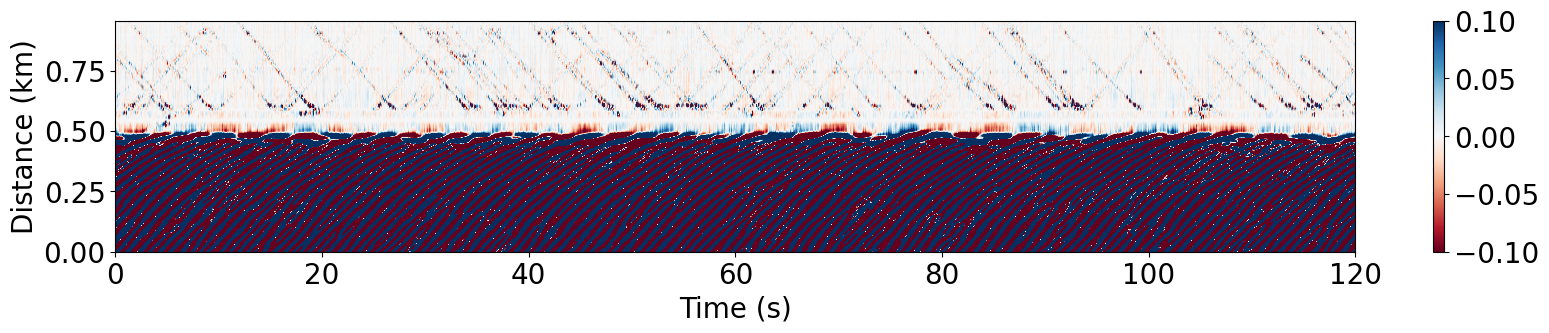

In [15]:
extent = [0, full_time_data.shape[1]/new_fs, 0, full_time_data.shape[0]*dx/1000]

plt.figure(figsize=(20, 3))
plt.imshow(full_time_data, aspect='auto', cmap='RdBu', vmin=-0.1, vmax=0.1, extent=extent)
plt.colorbar()
plt.xlabel('Time (s)')
plt.ylabel('Distance (km)')

#### Functions to calculate PPSD

In [16]:
### functions to calculate PDF of multiple channels
### Modified from Enthan Williams's code
def ppsd(data,fs,fmin,fmax):
    """
    data:  2D array, the statistics is calculated along axis=0
    fs: sampling rate
    fmin: minimum frequency for statistics
    fmax: maximum frequency for statictics
    """
    ns = data.shape[1]
    nx = data.shape[0]
    
    ### Demean, detrend
    data -= np.mean(data, axis=1, keepdims=True) 
    data = sgn.detrend(data, axis=1) 
    
    freq, spec = sgn.periodogram(data, fs, window='hamming', axis=-1)

    # spec = np.abs(np.fft.fft(data))
    # freq = np.fft.fftfreq(data.shape[1], 1/fs)

    freq = np.tile(freq,(nx,1)).flatten()

    # print(freq.shape, spec.shape)


    ### Generate PDF
    xbins = np.logspace(np.log10(fmin),np.log10(fmax),100)
    ybins = np.logspace(np.log10(np.nanmin(spec)),np.log10(np.nanmax(spec)),200)
    
    H,xe,ye = np.histogram2d(freq.flatten(), spec.flatten(), bins=(xbins,ybins))
  
    
    return H/np.nansum(H, axis=1, keepdims=True), (xe[1:] + xe[:-1])/2, (ye[1:] + ye[:-1])/2
    
def psd_stats(H,xm,ym):   
    ym = np.log10(ym)
    mean = np.zeros(len(xm))
    variance = mean.copy()
    for ix in range(len(xm)):
        mean[ix] = np.average(ym,weights=H[ix,:])
        variance[ix] = np.average((ym-mean[ix])**2,weights=H[ix,:])
    
    return xm,10**mean,variance

Defining parameters for 2024 OOI DAS

In [39]:
machine_name = 'optodas'               # interrogator name
num_proc = 2                          # number of threads (too large number kills the memory) 
start_ch, end_ch = 0, 9000             # channel range                       
start_file = 10                        # starting file indice for reading
num_file = 360                         # number of semi-continuous 1-min files to merge
dsamp_factor = 1                       # downsample rate when reading raw time series
new_fs = int(fs / dsamp_factor)        # final sample rate after downsampling
data_dir = os.path.join(rawdata_dir,'20240510/dphi/')

### parameters for PSD statistics
channel_bin = 200                      # channel bin for PSD statistics
half_bin = channel_bin//2              # half bin for PSD statistics
channel_interval = 2000                # channel number separating to segments
amp_type = 'strain_rate'               # amplitude type for PSD statistics
correction_factor = (1550.12 * 1e-9) / (0.78 * 4 * np.pi * 1.4677) # correction factor for strain rate


Defining parameters for Farm DAS

In [31]:
machine_name = 'onyx'                 # 'optodas' or 'onyx'
num_proc = 10                         # number of threads (too large number kills the memory) 
start_ch, end_ch = 44, 94             # channel range                       
start_file = 10                       # starting file indice for reading
num_file = 10                         # number of semi-continuous 1-min files to merge
dsamp_factor = 20                     # downsample rate when reading raw time series
new_fs = int(fs / dsamp_factor)       # final sample rate after downsampling
data_dir = '/1-fnp/petasaur/p-wd05/harper_plots'

### parameters for PSD statistics
channel_bin = 5                      # channel bin for PSD statistics
half_bin = channel_bin//2               # half bin for PSD statistics
channel_interval = 5                # channel number separating to segments
amp_type = 'strain'                 # amplitude type for PSD statistics
correction_factor = (1550 * 1e-9) / (0.78 * 4 * np.pi * 1.4682 * gl) # correction factor for strain rate

Read and decimate in parallel

In [40]:
file_list = np.array(os.listdir(data_dir))
file_list = file_list[np.argsort(file_list)]
file_path = [os.path.join(data_dir,i) for i in file_list]

since = time.time()

# %% multi-process to read and decimate lots of files 
partial_func = partial(read_decimate, dsamp_factor=dsamp_factor, start_ch=start_ch, end_ch=end_ch, machine_name=machine_name)
with Pool(processes=num_proc) as pool:   # pool is closed automatically and join as a list
    print("# threads: ", num_proc)
    full_time = pool.map(partial_func, file_path[start_file:start_file+num_file])

# %% concatenate the list elements in time
print("concatenating data")
full_time_data = np.concatenate(full_time, axis=1)

print(f'time used: {time.time()- since:.1f}')
print(f'final shape: {full_time_data.shape}')
print(f'sample rate: {new_fs:.0f}')

# threads:  2
concatenating data
time used: 67.0
final shape: (9000, 720000)
sample rate: 200


5it [00:55, 11.11s/it]


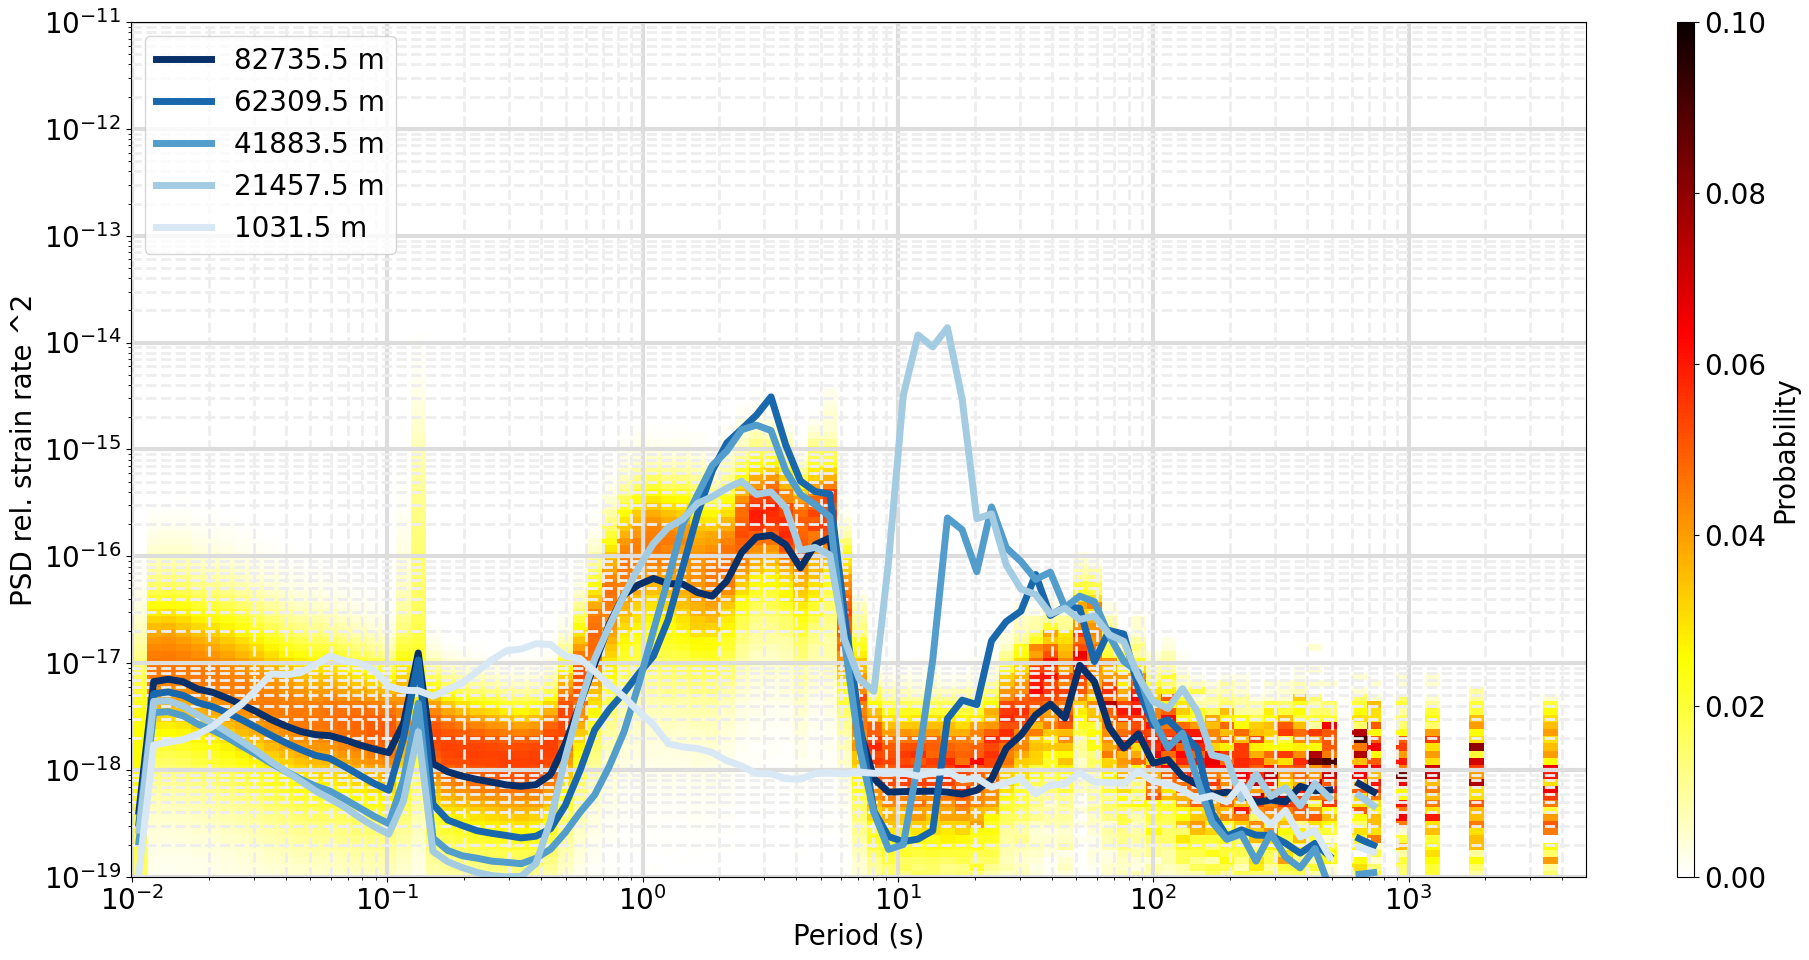

In [41]:
### Convert phase to strain/ strain rate
hour_data = full_time_data * correction_factor

### Plot PSD
fig,ax = plt.subplots(1,1,figsize=(20,10))

### divide into several segments, indicated by different colors
ch_list = np.arange(half_bin+1,(end_ch-start_ch),channel_interval)[::-1]
colors = matplotlib.colormaps['Blues'](np.linspace(0.15, 1, len(ch_list)))[::-1]

for i, chan in tqdm(enumerate(ch_list)):
    
    trs = hour_data[chan-half_bin:chan+half_bin,:]
    if amp_type == 'strain':
        trs = np.diff(trs, axis=1) * new_fs

    H,xm,ym = ppsd(trs,new_fs,2e-4,1e2)
    xm,mn,vr = psd_stats(H,xm,ym)

    ax.plot(1/xm, mn,linewidth=5, label='%.1f m' % (chan*dx), zorder=2, color=colors[i])
    if i == 0:
        img=ax.pcolormesh(1/xm,ym,H.T,cmap='hot_r',vmin=0,vmax=0.1, zorder=1)
        
ax.set_xscale('log')
ax.set_yscale('log')   
ax.set_ylim([1e-19,1e-11])
ax.set_xlabel('Period (s)')
ax.set_ylabel('PSD rel. strain rate ^2')
ax.grid(which='major', color='#DDDDDD', linewidth=3, zorder=0)
ax.grid(which='minor', color='#EEEEEE', linewidth=2, linestyle='--', zorder=0)
plt.colorbar(img, ax=ax, aspect=50).set_label('Probability')
plt.legend(loc="upper left")
plt.tight_layout()  